In [6]:
# notebook for new ircc dataset (combined_event_log_anonymous.csv)

# TODO
# √ mark subprocesses that are fully automated; incorporate in viewer
# in general, nesting subprocesses in dcr (paper)

In [7]:
# data/combined_event_log_anonymous.csv
# -> data/combined_event_log-filt_evt1p.csv
#   -> data/combined_event_log-filt_evt1p-time1m.csv

# subprocesses:
#   data/combined_event_log-filt_evt1p-time1m.csv
#   -> data/combined_event_log-abstracted.csv + sublogs in level2 (based on status) 
#       -> data/combined_event_log-abstracted2.csv + sublogs in level1 (based on nesting)

In [1]:
import pm4py
import pandas as pd
import numpy as np
from mine_utils import get_log

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Preprocess logs

## Variant analysis

In [9]:
# huge amount of variability

# total # traces = 7734 traces

# (non-abstr) new log: # vars = 7665, ratio = 99.10783553141971
#   (a variant covers at most 4 traces ...)
#   filter evts in less than X of cases:
#       1%: 7664 variants: minus 1 variant
#       10%: 7657 variants: minus 8 variants
#   same time for events within 1min:
#       ** 6030 variants: minus 1635 variants
#       + above (1%): 6014 variants: minus 1651 variants
#       + above (10%): 5841 variants: minus 1824 variants

# abstr new log: # vars = 5145, ratio = 66.5244375484872
#   same time for events within 1min: # vars = 3654, ratio = 47.25
#   + filter evts in less than 1% of cases: # vars = 3564, ratio = 46.08

# (abstr or log: # traces = 7734, # vars = 2642, ratio = 34.16084820274114)


In [2]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, get_covering_variants, filter_traces_on_variants

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_6827/2251509864.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log-filt_evt1p.csv")


# traces = 7734, # vars = 7664, ratio = 99.09


,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",4,0.05172,0.051720,0.013048
1,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",3,0.03879,0.090509,0.026096
2,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",3,0.03879,0.129299,0.039144
3,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",3,0.03879,0.168089,0.052192
4,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Exempt - Age, Study Permit Fee - Outstandi...",3,0.03879,0.206879,0.065240
...,...,...,...,...,...
7659,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",1,0.01293,99.948280,99.947808
7660,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",1,0.01293,99.961210,99.960856
7661,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",1,0.01293,99.974140,99.973904
7662,"(Application Status - Prospective, Misrepresentation - NIL, Eligibility Assessment - NIL, Final Assessment - NIL, Received - Date, Biometric Assessment - Required, Criminality - Not Started, Crimi...",1,0.01293,99.987070,99.986952


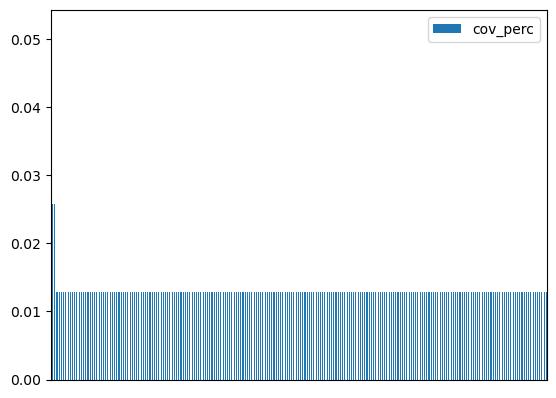

In [3]:
log = pd.read_csv("data/combined_event_log-filt_evt1p.csv")
vars_log = get_variants_stats(log)
print(get_variant_ratio(log, vars_log))
vars_log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_87637/3490178454.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log-time1m.csv")


# traces = 7734, # vars = 6030, ratio = 77.97


,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",42,0.543057,0.543057,0.016584
1,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",36,0.465477,1.008534,0.033167
2,"(Application Status - Prospective, Biometric Assessment - Required, Biometrics - RCMP - Not Started, Biometrics Fee - Outstanding, Biometrics Fee - Outstanding, Biometrics Fee - Paid, Biometrics F...",36,0.465477,1.474011,0.049751
3,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",26,0.336178,1.810189,0.066335
4,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",25,0.323248,2.133437,0.082919
...,...,...,...,...,...
6025,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.948280,99.933665
6026,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.961210,99.950249
6027,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.974140,99.966833
6028,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.987070,99.983416


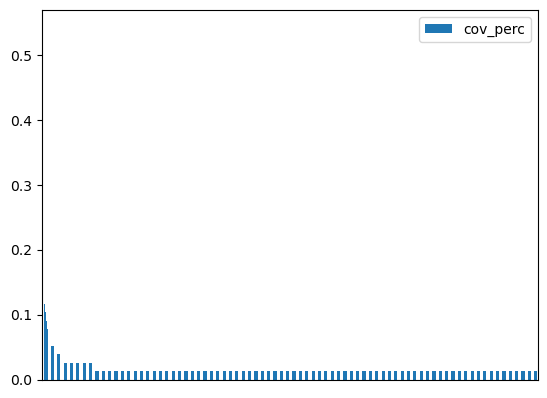

In [12]:
# much bigger improvement, clearly

log = pd.read_csv("data/combined_event_log-time1m.csv")
vars_log = get_variants_stats(log)
print(get_variant_ratio(log, vars_log))
vars_log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_91642/669204090.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")


# traces = 7734, # vars = 6014, ratio = 77.76


,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",42,0.543057,0.543057,0.016628
1,"(Application Status - Prospective, Biometric Assessment - Required, Biometrics - RCMP - Not Started, Biometrics Fee - Outstanding, Biometrics Fee - Outstanding, Biometrics Fee - Paid, Biometrics F...",36,0.465477,1.008534,0.033256
2,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",36,0.465477,1.474011,0.049884
3,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",26,0.336178,1.810189,0.066511
4,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",25,0.323248,2.133437,0.083139
...,...,...,...,...,...
6009,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.948280,99.933489
6010,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.961210,99.950116
6011,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.974140,99.966744
6012,"(Application Status - Open, Application Status - Prospective, Auto Promote - In Progress, Auto Promote - Not Started, Auto Promote - Submit, Auto Promote - Successful, Auto Promote Decision - In P...",1,0.012930,99.987070,99.983372


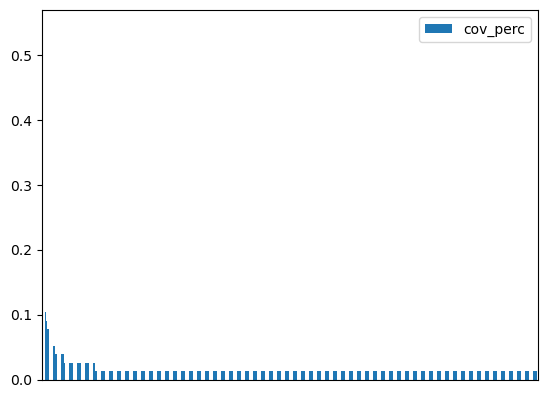

In [7]:
log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")
vars_log = get_variants_stats(log)
print(get_variant_ratio(log, vars_log))
vars_log

In [ ]:
log = pd.read_csv("data/combined_event_log_anonymous.csv")
log['act_upd_date'] = pd.to_datetime(log['act_upd_date'])
log = log.rename({ 'app_num': 'case:concept:name', 'activity_full_value': 'concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)

abstr_log_or = pd.read_csv("data/or/abstract_log-starts_ends-v2.csv")
abstr_log_new = pd.read_csv("data/combined_event_log-abstracted2.csv")

In [ ]:
print("total # traces:", len(log['case:concept:name'].unique()))

vars_log = get_variants_stats(log)
vars_abstr_log_or = get_variants_stats(abstr_log_or)
vars_abstr_log_new = get_variants_stats(abstr_log_new)

print("log:", get_variant_ratio(log, vars_log))
print("abstr log or:", get_variant_ratio(log, vars_abstr_log_or))
print("abstr log new:", get_variant_ratio(log, vars_abstr_log_new))

## Infrequent events

In [12]:
log = pd.read_csv("data/combined_event_log_anonymous.csv")
log = log.rename({ 'app_num': 'case:concept:name', 'activity_full_value': 'concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_6827/2480206813.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log_anonymous.csv")


In [13]:
log[log['activity']=='Other Reqs Assessment']['activity_status'].drop_duplicates()

51        Not Started
53        In Progress
61                NIL
6310        Cancelled
334858         Failed
456026         Passed
Name: activity_status, dtype: object

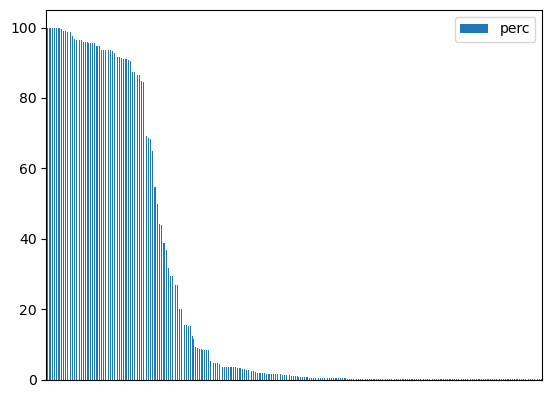

In [14]:
from log_stats import count_cases_per_event

activ_cases_counts = count_cases_per_event('concept:name', 'case:concept:name', log).reset_index()

In [15]:
activ_cases_counts[activ_cases_counts['perc']<1] #.to_csv("data/dropped_events.csv")

,concept:name,cases,perc
137,Study Permit Fee - Refund Request,74,0.956814
138,Study Permit Fee - Refund Complete,67,0.866305
139,Biometrics - RCMP - Received - IMM,63,0.814585
140,Auto Promote Decision - Not Started,61,0.788725
141,Biometrics - RCMP - Entered in Error,60,0.775795
...,...,...,...
269,Non-compliance - Passed,1,0.012930
270,Note Review - Review Complete,1,0.012930
271,Open Work Permit Holder Fee Fee - Outstanding,1,0.012930
272,Other Reqs Assessment - Failed,1,0.012930


In [16]:
activ_cases_counts[activ_cases_counts['perc']<10]

,concept:name,cases,perc
82,Medical - In Progress,708,9.154383
83,Medical Assessment - In Progress,688,8.895785
84,Medical Assessment - Sent,681,8.805275
85,Medical - Sent,681,8.805275
86,Biometric - FCC - NZ - Not Started,651,8.417378
...,...,...,...
269,Non-compliance - Passed,1,0.012930
270,Note Review - Review Complete,1,0.012930
271,Open Work Permit Holder Fee Fee - Outstanding,1,0.012930
272,Other Reqs Assessment - Failed,1,0.012930


In [17]:
# let's filter on activities that occur in 1% or less of cases
to_drop = activ_cases_counts.loc[activ_cases_counts['perc']<1, 'concept:name']
log_filter = log[~ log['concept:name'].isin(to_drop)]

In [18]:
log_filter.to_csv("data/combined_event_log-filt_evt1p.csv")

## Timestamp differences

In [ ]:
# log = pd.read_csv("data/combined_event_log_anonymous.csv")

log = pd.read_csv("data/combined_event_log-filt_evt1p.csv")
log = log.drop('Unnamed: 0', axis=1)

log = log.rename({ 'app_num': 'case:concept:name', 'activity_full_value': 'concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

In [ ]:
from mine_utils import get_time_diff, equal_timestamps_interval

In [ ]:
log = get_time_diff(log)

In [ ]:
log[log['activity']=='Associate Medicals'].groupby('case:concept:name')['time_diff'].mean().mean()

In [ ]:
# (check all sequential events with exact same timestamp)
print("num simult (0 sec):", len(log[log['time_diff']==0]), " <> total num:", log.shape[0])

In [ ]:
# (check all sequential events with less than 1min difference in timestamps)
print("num simult (1 min):", len(log[log['time_diff'] < 60]), " <> total num:", log.shape[0])

In [ ]:
# (takes ca. 2-4 sec)

log = equal_timestamps_interval(log, 60) # 60 sec

In [ ]:
# log.to_csv("data/combined_event_log-time1m.csv")
log.to_csv("data/combined_event_log-filt_evt1p-time1m.csv")

# checkout variant analysis for seeing whether it improved matters

# Subprocesses

In [ ]:
src_file = "data/combined_event_log-filt_evt1p.csv"
# src_file = "data/combined_event_log-filt_evt1p-time1m.csv"

tgt_folder = "lifecycles/filt_evt1p/data"

## Subprocesses based on status

In [51]:
# log = pd.read_csv("data/combined_event_log_anonymous.csv")
# log = log.rename({ 'app_num': 'case:concept:name', 'act_upd_date': 'time:timestamp' }, axis=1)

log = pd.read_csv(src_file)
log = log.drop('Unnamed: 0', axis=1)
log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_6827/2361279229.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv(src_file)


,case:concept:name,time:timestamp,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name
0,0,2024-06-03 09:20:37.327,0,1-SQ1RI5F,NaN,Application Status,Prospective,Vietnam,Vietnam,Application Status - Prospective
1,0,2024-06-03 09:20:37.327,1,0,NaN,Misrepresentation,NIL,Vietnam,Vietnam,Misrepresentation - NIL
2,0,2024-06-03 09:20:37.327,1,0,NaN,Eligibility Assessment,NIL,Vietnam,Vietnam,Eligibility Assessment - NIL
3,0,2024-06-03 09:20:37.327,1,0,NaN,Final Assessment,NIL,Vietnam,Vietnam,Final Assessment - NIL
4,0,2024-06-03 09:20:37.327,1,0,NaN,Received,Date,Vietnam,Vietnam,Received - Date
...,...,...,...,...,...,...,...,...,...,...
541091,7733,2024-06-17 07:46:39.433,281,1-STC2A6X,NaN,Other Reqs Assessment,NIL,Belgium,Cameroon,Other Reqs Assessment - NIL
541092,7733,2024-06-26 08:11:25.043,281,1-STC2A6X,NaN,Eligibility Assessment,Review Required,Belgium,Cameroon,Eligibility Assessment - Review Required
541093,7733,2024-06-28 10:45:09.050,281,1-STC2A6X,NaN,Eligibility Assessment,Failed,Belgium,Cameroon,Eligibility Assessment - Failed
541094,7733,2024-06-28 10:45:09.587,281,1-STC2A6X,NaN,Final Assessment,Refused,Belgium,Cameroon,Final Assessment - Refused


In [52]:
# get all unique activities
log['activity'].drop_duplicates().sort_values().to_excel("data/all_activities.xlsx")

In [53]:
# get activity subprocesses
activ_lifecycles = log[['activity', 'activity_status']].drop_duplicates().sort_values(by=['activity'])
activ_lifecycles.to_excel("data/activity_lifecycles.xlsx")

In [54]:
# count number of sub-activities in each subprocess
counts = log[['activity', 'activity_status']].drop_duplicates().groupby('activity')['activity_status'].count()
counts = counts.sort_values(ascending=False)
counts

activity
Biographic                      12
Biometric - FCC - USA           10
Verification                     6
Eligibility Assessment           6
Candidate ID                     6
Medical Assessment               5
Criminality Assessment           5
Criminality                      5
Integrated Search                5
Candidate ID Decision            5
Medical                          5
Biometrics - RCMP                5
Biometric - FCC Detail - USA     5
Auto Promote                     5
Identity Verification            4
Biometric Assessment             4
Candidate Search                 4
Biometric - FCC - NZ             4
Auto Promote Decision            4
Associate Medicals               4
Final Assessment                 4
Other Reqs Assessment            4
Application Status               3
Post Identity Checks             3
Study Permit Fee                 2
Work Permit Fee                  2
Identity Review                  2
Biometrics Fee                   2
Biometrics 

In [55]:
# only separate subprocesses with >= 3 sub-activities
parent_activ = counts[counts >= 3].reset_index()
parent_activ

,activity,activity_status
0,Biographic,12
1,Biometric - FCC - USA,10
2,Verification,6
3,Eligibility Assessment,6
4,Candidate ID,6
5,Medical Assessment,5
6,Criminality Assessment,5
7,Criminality,5
8,Integrated Search,5
9,Candidate ID Decision,5


In [56]:
subproc_evts = log[log['activity'].isin(parent_activ['activity'])]
subproc_evts

,case:concept:name,time:timestamp,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name
0,0,2024-06-03 09:20:37.327,0,1-SQ1RI5F,NaN,Application Status,Prospective,Vietnam,Vietnam,Application Status - Prospective
2,0,2024-06-03 09:20:37.327,1,0,NaN,Eligibility Assessment,NIL,Vietnam,Vietnam,Eligibility Assessment - NIL
3,0,2024-06-03 09:20:37.327,1,0,NaN,Final Assessment,NIL,Vietnam,Vietnam,Final Assessment - NIL
5,0,2024-06-03 09:20:38.890,2,1-SQ1RI5F,NaN,Biometric Assessment,Required,Vietnam,Vietnam,Biometric Assessment - Required
6,0,2024-06-03 09:20:39.023,3,1-SQ1RI7P,NaN,Criminality,Not Started,Vietnam,Vietnam,Criminality - Not Started
...,...,...,...,...,...,...,...,...,...,...
541091,7733,2024-06-17 07:46:39.433,281,1-STC2A6X,NaN,Other Reqs Assessment,NIL,Belgium,Cameroon,Other Reqs Assessment - NIL
541092,7733,2024-06-26 08:11:25.043,281,1-STC2A6X,NaN,Eligibility Assessment,Review Required,Belgium,Cameroon,Eligibility Assessment - Review Required
541093,7733,2024-06-28 10:45:09.050,281,1-STC2A6X,NaN,Eligibility Assessment,Failed,Belgium,Cameroon,Eligibility Assessment - Failed
541094,7733,2024-06-28 10:45:09.587,281,1-STC2A6X,NaN,Final Assessment,Refused,Belgium,Cameroon,Final Assessment - Refused


In [57]:
non_subproc_evts = log[~ log['activity'].isin(parent_activ['activity'])]
non_subproc_evts

,case:concept:name,time:timestamp,act_upd_by,activity_id,group,activity,activity_status,cor,citz,concept:name
1,0,2024-06-03 09:20:37.327,1,0,NaN,Misrepresentation,NIL,Vietnam,Vietnam,Misrepresentation - NIL
4,0,2024-06-03 09:20:37.327,1,0,NaN,Received,Date,Vietnam,Vietnam,Received - Date
11,0,2024-06-03 09:20:45.000,4,1-SQ1190E,NaN,Biometrics Fee,Outstanding,Vietnam,Vietnam,Biometrics Fee - Outstanding
12,0,2024-06-03 09:20:45.000,4,1-SQ1190H,NaN,Study Permit Fee,Outstanding,Vietnam,Vietnam,Study Permit Fee - Outstanding
13,0,2024-06-03 09:20:45.000,4,1-SQ1190E,NaN,Biometrics Fee,Paid,Vietnam,Vietnam,Biometrics Fee - Paid
...,...,...,...,...,...,...,...,...,...,...
541044,7733,2024-06-06 10:37:08.000,1092,1-STC2A8X,NaN,Biometrics Fee,Paid,Belgium,Cameroon,Biometrics Fee - Paid
541045,7733,2024-06-06 10:37:10.000,1092,1-STC2A8U,NaN,Study Permit Fee,Outstanding,Belgium,Cameroon,Study Permit Fee - Outstanding
541046,7733,2024-06-06 10:37:10.000,1092,1-STC2A8X,NaN,Biometrics Fee,Outstanding,Belgium,Cameroon,Biometrics Fee - Outstanding
541047,7733,2024-06-06 10:37:10.000,1092,1-STC2A8U,NaN,Study Permit Fee,Paid,Belgium,Cameroon,Study Permit Fee - Paid


### Create separate logs per subprocess

In [58]:
from separ_subproc import separ_subproc

separ_subproc(subproc_evts, non_subproc_evts, 'activity', 'activity_status', 'concept:name', f"{tgt_folder}/level2/", f"{tgt_folder}/combined_event_log-abstracted_status.csv")

Application Status (# events: 23263)
Associate Medicals (# events: 1097)
Auto Promote (# events: 29528)
Auto Promote Decision (# events: 22250)
Biographic (# events: 30777)
Biometric - FCC - NZ (# events: 2586)
Biometric - FCC - USA (# events: 30328)
Biometric - FCC Detail - USA (# events: 4734)
Biometric Assessment (# events: 14929)
Biometrics - RCMP (# events: 25579)
Candidate ID (# events: 29864)
Candidate ID Decision (# events: 23962)
Candidate Search (# events: 23534)
Criminality (# events: 21929)
Criminality Assessment (# events: 21927)
Eligibility Assessment (# events: 19051)
Final Assessment (# events: 15772)
Identity Verification (# events: 1120)
Integrated Search (# events: 31244)
Medical (# events: 6652)
Medical Assessment (# events: 6636)
Other Reqs Assessment (# events: 20615)
Post Identity Checks (# events: 819)
Verification (# events: 27317)


,case:concept:name,activity,time:timestamp,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name
0,0,Application Status,2024-06-03 09:20:37.327,0,1-SQ1RI5F,None,Prospective,Vietnam,Vietnam,Application Status [begin]
12,0,Eligibility Assessment,2024-06-03 09:20:37.327,1,0,None,NIL,Vietnam,Vietnam,Eligibility Assessment [begin]
13,0,Final Assessment,2024-06-03 09:20:37.327,1,0,None,NIL,Vietnam,Vietnam,Final Assessment [begin]
270950,0,Misrepresentation,2024-06-03 09:20:37.327,1,0,None,NIL,Vietnam,Vietnam,Misrepresentation - NIL
270951,0,Received,2024-06-03 09:20:37.327,1,0,None,Date,Vietnam,Vietnam,Received - Date
...,...,...,...,...,...,...,...,...,...,...
270949,7733,Verification,2024-06-17 07:46:39.197,9,1-STCSFDC,None,Completed,Belgium,Cameroon,Verification [end]
270948,7733,Other Reqs Assessment,2024-06-17 07:46:39.433,281,1-STC2A6X,None,NIL,Belgium,Cameroon,Other Reqs Assessment [end]
270945,7733,Eligibility Assessment,2024-06-28 10:45:09.050,281,1-STC2A6X,None,Failed,Belgium,Cameroon,Eligibility Assessment [end]
270946,7733,Final Assessment,2024-06-28 10:45:09.587,281,1-STC2A6X,None,Refused,Belgium,Cameroon,Final Assessment [end]


## Subprocesses based on nesting

### Check original nesting file

In [59]:
nestings = pd.read_excel("data/nested_activities-original.xlsx")
log = pd.read_csv("data/combined_event_log_anonymous.csv")

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_6827/1550013220.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("data/combined_event_log_anonymous.csv")


In [60]:
nestings[~ (nestings['Activity'].isin(log['activity']))]

,Activity,Parent Item
0,A39,Other Req Assessment
7,Biometric - FCC Detail - NZ,Info Sharing Assessment
10,Biometric - FCC Reciprocal - NZ,Info Sharing Assessment
11,Biometric - FCC Reciprocal - USA,Info Sharing Assessment
12,Biometric - RCMP,Criminality Activity
14,Cost Recovery,Biometrics Family Rate Fee
15,Cost Recovery,Biometrics Fee
16,Cost Recovery,Open Work Permit Holder Fee Fee
17,Cost Recovery,Overpayment Fee
18,Cost Recovery,Study Permit Fee


In [61]:
cost_recov = nestings[nestings['Activity']=='Cost Recovery']['Parent Item']
cost_recov[~ (cost_recov.isin(log['activity']))]

Series([], Name: Parent Item, dtype: object)

In [62]:
print(len(log[log['activity']=='Criminality Assessment']))
print(len(log[log['activity']=='Medical Assessment']))
print(len(log[log['activity']=='Misrep Assessment']))
print(len(log[log['activity']=='Security Assessment']))

21927
6675
144
41


In [63]:
print(log[log['activity'].str.startswith('Biographic')]['activity'].drop_duplicates())
print()
print(log[log['activity'].str.startswith('Biometric')]['activity'].drop_duplicates())
print()
print(log[log['activity'].str.startswith('Criminal')]['activity'].drop_duplicates())
print()
print(log[log['activity'].str.startswith('Medical')]['activity'].drop_duplicates())
print()
print(log[log['activity'].str.startswith('Security')]['activity'].drop_duplicates())

48                     Biographic
181248    Biographic - Correction
Name: activity, dtype: object

5                     Biometric Assessment
10                       Biometrics - RCMP
11                          Biometrics Fee
49                   Biometric - FCC - USA
327           Biometric - FCC Detail - USA
1673            Biometrics Family Rate Fee
3739                  Biometric - FCC - NZ
120969               Biometric - FCC - AUS
120976        Biometric - FCC Detail - AUS
382302    Biometric - FCC Reciprocal - AUS
Name: activity, dtype: object

6               Criminality
7    Criminality Assessment
Name: activity, dtype: object

70               Medical
72    Medical Assessment
Name: activity, dtype: object

4904               Security
4905    Security Assessment
Name: activity, dtype: object


### Find subprocesses

In [64]:
nestings = pd.read_excel("data/nested_activities-fixed.xlsx")
nestings

,Activity,Parent Item
0,Associate Medicals,Medical Activity
1,Biographic,Info Sharing Assessment
2,Biographic - Correction,Info Sharing Assessment
3,Biometric - FCC - AUS,Info Sharing Assessment
4,Biometric - FCC - NZ,Info Sharing Assessment
5,Biometric - FCC - USA,Info Sharing Assessment
6,Biometric - FCC Detail - AUS,Info Sharing Assessment
7,Biometric - FCC Detail - USA,Info Sharing Assessment
8,Biometric - FCC Reciprocal - AUS,Info Sharing Assessment
9,Biometric Assessment,Info Sharing Assessment


In [65]:
# make sure there's no non-existent activities in the nesting file
or_log = pd.read_csv("data/combined_event_log_anonymous.csv")
nestings[~ nestings['Activity'].isin(or_log['activity'])].sort_values(by='Activity')

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_6827/4061471006.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  or_log = pd.read_csv("data/combined_event_log_anonymous.csv")


,Activity,Parent Item


In [66]:
abstr_log = pd.read_csv(f"{tgt_folder}/combined_event_log-abstracted_status.csv")
abstr_log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_6827/3098442383.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  abstr_log = pd.read_csv(f"{tgt_folder}/combined_event_log-abstracted_status.csv")


,case:concept:name,activity,time:timestamp,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name
0,0,Application Status,2024-06-03 09:20:37.327,0,1-SQ1RI5F,NaN,Prospective,Vietnam,Vietnam,Application Status [begin]
1,0,Eligibility Assessment,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Eligibility Assessment [begin]
2,0,Final Assessment,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Final Assessment [begin]
3,0,Misrepresentation,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Misrepresentation - NIL
4,0,Received,2024-06-03 09:20:37.327,1,0,NaN,Date,Vietnam,Vietnam,Received - Date
...,...,...,...,...,...,...,...,...,...,...
376528,7733,Verification,2024-06-17 07:46:39.197,9,1-STCSFDC,NaN,Completed,Belgium,Cameroon,Verification [end]
376529,7733,Other Reqs Assessment,2024-06-17 07:46:39.433,281,1-STC2A6X,NaN,NIL,Belgium,Cameroon,Other Reqs Assessment [end]
376530,7733,Eligibility Assessment,2024-06-28 10:45:09.050,281,1-STC2A6X,NaN,Failed,Belgium,Cameroon,Eligibility Assessment [end]
376531,7733,Final Assessment,2024-06-28 10:45:09.587,281,1-STC2A6X,NaN,Refused,Belgium,Cameroon,Final Assessment [end]


In [67]:
# connect parent items to events
# left merge; also keep events that are not being nested
abstr_log_parent = abstr_log.merge(nestings, left_on='activity', right_on='Activity', how='left')
abstr_log_parent

,case:concept:name,activity,time:timestamp,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name,Activity,Parent Item
0,0,Application Status,2024-06-03 09:20:37.327,0,1-SQ1RI5F,NaN,Prospective,Vietnam,Vietnam,Application Status [begin],NaN,NaN
1,0,Eligibility Assessment,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Eligibility Assessment [begin],NaN,NaN
2,0,Final Assessment,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Final Assessment [begin],NaN,NaN
3,0,Misrepresentation,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Misrepresentation - NIL,NaN,NaN
4,0,Received,2024-06-03 09:20:37.327,1,0,NaN,Date,Vietnam,Vietnam,Received - Date,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
376528,7733,Verification,2024-06-17 07:46:39.197,9,1-STCSFDC,NaN,Completed,Belgium,Cameroon,Verification [end],Verification,Other Req Activity
376529,7733,Other Reqs Assessment,2024-06-17 07:46:39.433,281,1-STC2A6X,NaN,NIL,Belgium,Cameroon,Other Reqs Assessment [end],Other Reqs Assessment,Other Req Activity
376530,7733,Eligibility Assessment,2024-06-28 10:45:09.050,281,1-STC2A6X,NaN,Failed,Belgium,Cameroon,Eligibility Assessment [end],NaN,NaN
376531,7733,Final Assessment,2024-06-28 10:45:09.587,281,1-STC2A6X,NaN,Refused,Belgium,Cameroon,Final Assessment [end],NaN,NaN


In [68]:
subproc_evts = abstr_log_parent[abstr_log_parent['Parent Item'].notna()]
# (non-nested events; those not merged with parent)
non_subproc_evts = abstr_log_parent[abstr_log_parent['Parent Item'].isna()]

### Create separate logs per nested activity

In [ ]:
from separ_subproc import separ_subproc
from shutil import copy

separ_subproc(subproc_evts, non_subproc_evts, 'Parent Item', 'concept:name', 'concept:name', f"{tgt_folder}/level1", f"{tgt_folder}/combined_event_log-abstracted_nesting.csv")

copy(f"{tgt_folder}/combined_event_log-abstracted_nesting.csv", f"{tgt_folder}/level0/main.csv")

Cost Recovery (# events: 82369)
Criminality Activity (# events: 43613)
Info Sharing Assessment (# events: 50046)
Medical Activity (# events: 12728)
Other Req Activity (# events: 27988)


,case:concept:name,Parent Item,activity,time:timestamp,act_upd_by,activity_id,group,activity_status,cor,citz,concept:name,Activity
65294,0,NaN,Application Status,2024-06-03 09:20:37.327,0,1-SQ1RI5F,NaN,Prospective,Vietnam,Vietnam,Application Status [begin],NaN
65295,0,NaN,Eligibility Assessment,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Eligibility Assessment [begin],NaN
65296,0,NaN,Final Assessment,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Final Assessment [begin],NaN
65297,0,NaN,Misrepresentation,2024-06-03 09:20:37.327,1,0,NaN,NIL,Vietnam,Vietnam,Misrepresentation - NIL,NaN
65298,0,NaN,Received,2024-06-03 09:20:37.327,1,0,NaN,Date,Vietnam,Vietnam,Received - Date,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
65292,7733,Info Sharing Assessment,Biometric - FCC - USA,2024-06-11 23:52:27.260,18,1-STCSFD6,None,NRT,Belgium,Cameroon,Info Sharing Assessment [end],Biometric - FCC - USA
65293,7733,Other Req Activity,Other Reqs Assessment,2024-06-17 07:46:39.433,281,1-STC2A6X,None,NIL,Belgium,Cameroon,Other Req Activity [end],Other Reqs Assessment
225080,7733,NaN,Eligibility Assessment,2024-06-28 10:45:09.050,281,1-STC2A6X,NaN,Failed,Belgium,Cameroon,Eligibility Assessment [end],NaN
225081,7733,NaN,Final Assessment,2024-06-28 10:45:09.587,281,1-STC2A6X,NaN,Refused,Belgium,Cameroon,Final Assessment [end],NaN


## Sanity check

In [ ]:
import os

dir = "lifecycles/level2/logs"
sublogs_lvl2 = [ (f, pd.read_csv(os.path.join(dir, f))) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) ]

FileNotFoundError: [Errno 2] No such file or directory: 'lifecycles/level2/logs'

### Check original events

In [ ]:
# same input as subprocesses part
# (NOTE - original log will have to be extended with index for sanity code to work)
log = pd.read_csv("data/combined_event_log-filt_evt1p-time1m.csv")

In [ ]:
from collections import defaultdict

found_indexes = set()

# > subprocesses based on status

# - find original events in the sublogs

for f, sublog in sublogs_lvl2:    
    f_name = f[0:f.index(".")]
    
    # join original log with the sublog
    log_merged = log.merge(sublog, left_on='index', right_on='index')
    # print(log_merged)
    
    # (apply same string operation as on the file name)
    activ_file = (log_merged['activity_x'].str.replace("/", "_") == f_name)
    # for all matches, activity names should correspond to file name
    assert (activ_file).all(), f_name + " <> " + log_merged[~ activ_file]['activity_x']
    # for all matches, activity statuses should correspond to sublog activity name
    assert (log_merged['activity_status'] == log_merged['concept:name_y']).all(), "file: {f_name}"
    
    found_indexes.update(log_merged['index'])

In [ ]:
# - find original events in the abstracted log

# only interested in activities without parent (non-nested)
log_filter = log[~ log['activity'].isin(parent_activ['activity'])]
# join original log with the abstracted log
log_merged = log_filter.merge(abstr_log, left_on='index', right_on='index')
# print(log_merged)

activ_name = (log_merged['concept:name_x'] == log_merged['concept:name_y'])
# activity names should correspond
assert (activ_name).all(), log_merged[~ activ_name][['concept:name_x', 'concept:name_y']]

found_indexes.update(log_merged['index'])

In [ ]:
# all events found?
assert len(found_indexes) == log.shape[0], f"{len(found_indexes)} <> {log.shape[0]}"

### Check subprocesses

In [ ]:
# > subprocesses based on nesting

# per case, check if activity's start/end markers correspond to first & last sorted events of the activity

def check_subproc(abstr_log, marker_label, is_start):
    # group all start/end markers by activity
    groups = abstr_log[abstr_log['concept:name'].str.endswith(marker_label)].groupby('activity')

    # for each activity & their markers for all cases
    for activ, g in groups:
        # sort on case
        g = g.sort_values(by='case:concept:name').reset_index()
        
        # find sublog corresponding to activity
        for i in [ 1, 2 ]:
            path = f"lifecycles/level2/logs/{activ.replace('/', '_')}.csv"
            if not os.path.exists(path):
                continue
            sublog = pd.read_csv(path)
        
        # print(activ, path)
        
        # first, in the activity's sublog, find the firsts/lasts for each case
        gb = sublog.groupby('case:concept:name')
        delims = (gb.first() if is_start else gb.last()).reset_index()
        # also sort on case
        delims = delims.sort_values(by='case:concept:name').reset_index()
        
        # firsts/lasts should be the same as the start/end markers
        assert(g['index'] == delims['index']).all(), activ
        
check_subproc(abstr_log, " [begin]", True)
check_subproc(abstr_log, " [end]", False)

path = "lifecycles/level1/logs/"

from pathlib import Path
paths = Path(path).rglob("*.csv")
for path in paths:
    abstr_sublog = pd.read_csv(path)
    check_subproc(abstr_sublog, " [begin]", True)
    check_subproc(abstr_sublog, " [end]", False)
    

## Variant analysis (bis)

### Main variant (no filtering)

In [ ]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, get_covering_variants, filter_traces_on_variants

In [ ]:
log = get_log("data/combined_event_log-abstracted2.csv")
log = log[['case:concept:name', 'concept:name', 'time:timestamp']]

In [ ]:
var_stats = get_variants_stats(log)
print(get_variant_ratio(log, var_stats))
var_stats

In [ ]:
singleton_vars = var_stats[var_stats['cov_amt']==1]

# ooph, a lot of traces here ...
singleton_vars['cov_amt'].sum() / var_stats['cov_amt'].sum()

### Subprocess variants (filtering!)

In [ ]:
# some ad-hoc analysis

# log = pd.read_csv("/Users/wvw/git/pm/ircc/lifecycles/level1/logs/Other Req Activity.csv")
# var_stats = get_variants_stats(log, plot=False)
# print(var_stats)
# rare_vars = var_stats[var_stats['cov_perc'] < 1]
# print()
# print(rare_vars['cov_perc'].sum().round(2))
# print((rare_vars['sequence'].count() / var_stats.shape[0] * 100).round(2))

In [ ]:
# filter the variants
# (ca. 3-5 s)

dir = "/Users/wvw/git/pm/ircc/lifecycles"
for subdir in [ "level1", "level2" ]:
    print(">", subdir)
    for path in Path(os.path.join(dir, subdir, "logs")).rglob("*.csv"):
        name = os.path.basename(path)
        log = pd.read_csv(path)
        var_stats = get_variants_stats(log, plot=False)
        
        rare_vars = var_stats[var_stats['cov_perc'] < 1]
        print(name, ":", rare_vars['cov_perc'].sum().round(2), "% traces", "(", (rare_vars['sequence'].count() / var_stats.shape[0] * 100).round(2), "% vars" ")")
        
        flog = filter_traces_on_variants(log, var_stats[var_stats['cov_perc'] >= 1])
        flog.to_csv(path)

    print()

## (Timestamp differences (bis))

In [ ]:
log = get_log("data/combined_event_log-abstracted2.csv")
log = log[['case:concept:name', 'concept:name', 'time:timestamp']]
log

In [ ]:
from mine_utils import get_time_diff

logd = get_time_diff(log)

In [ ]:
# (check all sequential events with less than 1min difference in timestamps)
print("num simult (1 min):", len(logd[ (logd['time_diff'] > 0) & (logd['time_diff'] < 60)]), " <> total num:", logd.shape[0])

# none to be found

## (Infrequent events (bis))

In [ ]:
log = pd.read_csv("data/combined_event_log-abstracted2.csv")

from log_stats import count_cases_per_event
activ_cases_counts = count_cases_per_event('concept:name', 'case:concept:name', log).reset_index()

In [ ]:
activ_cases_counts[activ_cases_counts['perc']<1]

# Mine process models

## Ad-hoc mining

In [ ]:
from variant_stats import get_variants_stats, get_variant_ratio, get_variant_coverage, get_covering_variants, filter_traces_on_variants
from mine_utils import get_log, ProcAnn, mine_heur, mine_induct, mine_alpha, mine_dfg

### Main process

In [ ]:
log = get_log("data/combined_event_log-abstracted2.csv")

cost_recov = log[(log['concept:name']=='Cost Recovery [begin]') | (log['concept:name']=='Cost Recovery [end]')]

log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
cost_recov.to_csv("data/cost_recov.csv")
xes_export.apply(cost_recov, "data/cost_recov.xes")

mine_heur(log, ProcAnn.FREQ, "graphs/combined_event_log-abstracted2-time1m")
mine_induct(log, convert_to='petri_net', output_path="graphs/combined_event_log-abstracted2-time1m-pn")

log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
xes_export.apply(log, "data/combined_event_log-abstracted2.xes")

### Subprocess

In [ ]:
verif = get_log("/Users/wvw/git/pm/ircc/lifecycles/level2/logs/Verification.csv")
verif

In [ ]:
vars = get_variants_stats(verif)
vars

In [ ]:
mine_dfg(verif)

## Systematic mining

In [72]:
tgt_folder = "lifecycles/filt_evt1p"

In [73]:
from mine_utils import ProcAnn, mine_heur, mine_induct, mine_alpha, mine_dfg
import pm4py.objects.log.exporter.xes.exporter as xes_export
from pathlib import Path

In [74]:
import shutil, os

def init_subdir(subdir, subsubdirs=[]):
    if os.path.exists(subdir):
        shutil.rmtree(subdir)
    os.mkdir(subdir)
    for subsubdir in subsubdirs:
        os.mkdir(os.path.join(subdir, subsubdir))

In [75]:
induct_formats = ['bpmn', 'petri_net']
formats_with_ann = ['dfg']

In [76]:
def save_entries_json(names, default_format, default_ann, path):
    def entry_pref():
        if default_format in formats_with_ann:
            return f"{{ \"format\": \"{default_format}\", \"ann\": \"{default_ann.value}\" }}"
        else:
            return f"{{ \"format\": \"{default_format}\" }}"
    
    all = "[" + ", ".join(map(lambda n: f"\"{n}\"", names)) + "]"
    prefs = "{" + ", ".join(map(lambda n: f"\"{n}\": {entry_pref()}", names)) + "}"
    obj = f"{{ \"all\": {all}, \"prefs\": {prefs} }}"
    open(os.path.join(path, "graphs.json"), "w").write(obj)

In [77]:
# mine process models for sublogs
# (ca. 1 min)

for lvl in [ 1, 2 ]:
    # subprocess level (levels 1-2)
    subdir = os.path.join(tgt_folder, f"level{lvl}")

    # default model & annotation to be shown
    default_format = "bpmn"
    default_ann = ProcAnn.FREQ

    init_subdir(os.path.join(subdir, "xes"))
    init_subdir(os.path.join(subdir, "dfg"), [ ProcAnn.FREQ.value, ProcAnn.PERF.value ])
    init_subdir(os.path.join(subdir, "heur"), [ ProcAnn.FREQ.value, ProcAnn.PERF.value ])
    for format in induct_formats:
        init_subdir(os.path.join(subdir, format))

    names = [ ]
    for path in Path(os.path.join(tgt_folder, "data", f"level{lvl}")).rglob("*.csv"):
        file = os.path.basename(path)
        name = file[0: file.index(".csv")]
        print(name)
        names.append(name)
        
        log = pd.read_csv(path)
        log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
        
        log['case:concept:name'] = log['case:concept:name'].astype('int64')
        log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])
        
        xes_export.apply(log, os.path.join(subdir, "xes", name + ".xes"))
        
        for ann in ProcAnn:
            mine_dfg(log, ann, output_path=os.path.join(subdir, "dfg", ann.value, name), save_gviz=True)
            mine_heur(log, ann, output_path=os.path.join(subdir, "heur", ann.value, name), save_gviz=True)
        
        for format in induct_formats:
            mine_induct(log, convert_to=format, output_path=os.path.join(subdir, format, name), save_gviz=True)

    save_entries_json(names, default_format, default_ann, subdir)

Medical Activity


exporting log, completed traces ::   0%|          | 0/3163 [00:00<?, ?it/s]

Other Req Activity


exporting log, completed traces ::   0%|          | 0/6780 [00:00<?, ?it/s]

Info Sharing Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Cost Recovery


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Criminality Activity


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Candidate ID Decision


exporting log, completed traces ::   0%|          | 0/7512 [00:00<?, ?it/s]

Associate Medicals


exporting log, completed traces ::   0%|          | 0/280 [00:00<?, ?it/s]

Biometric - FCC - NZ


exporting log, completed traces ::   0%|          | 0/658 [00:00<?, ?it/s]

Candidate Search


exporting log, completed traces ::   0%|          | 0/7651 [00:00<?, ?it/s]

Identity Verification


exporting log, completed traces ::   0%|          | 0/280 [00:00<?, ?it/s]

Candidate ID


exporting log, completed traces ::   0%|          | 0/7457 [00:00<?, ?it/s]

Auto Promote Decision


exporting log, completed traces ::   0%|          | 0/7415 [00:00<?, ?it/s]

Eligibility Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Biometric Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Criminality


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Auto Promote


exporting log, completed traces ::   0%|          | 0/7388 [00:00<?, ?it/s]

Criminality Assessment


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Medical Assessment


exporting log, completed traces ::   0%|          | 0/3042 [00:00<?, ?it/s]

Biographic


exporting log, completed traces ::   0%|          | 0/7711 [00:00<?, ?it/s]

Verification


exporting log, completed traces ::   0%|          | 0/6768 [00:00<?, ?it/s]

Integrated Search


exporting log, completed traces ::   0%|          | 0/7650 [00:00<?, ?it/s]

Other Reqs Assessment


exporting log, completed traces ::   0%|          | 0/6775 [00:00<?, ?it/s]

Biometric - FCC Detail - USA


exporting log, completed traces ::   0%|          | 0/1188 [00:00<?, ?it/s]

Post Identity Checks


exporting log, completed traces ::   0%|          | 0/282 [00:00<?, ?it/s]

Final Assessment


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

Biometric - FCC - USA


exporting log, completed traces ::   0%|          | 0/7732 [00:00<?, ?it/s]

Medical


exporting log, completed traces ::   0%|          | 0/3042 [00:00<?, ?it/s]

Biometrics - RCMP


exporting log, completed traces ::   0%|          | 0/7236 [00:00<?, ?it/s]

Application Status


exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

In [78]:
# mine models for main process
# (ca. 30-40 sec)

log = pd.read_csv(os.path.join(tgt_folder, "data", "level0", "main.csv"))
log = log[['case:concept:name', 'time:timestamp', 'concept:name']]
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

subdir = os.path.join(tgt_folder, "level0")

default_format = "dcr"
default_ann = ProcAnn.FREQ

init_subdir(os.path.join(subdir, "logs"))
init_subdir(os.path.join(subdir, "dfg"), [ ProcAnn.FREQ.value, ProcAnn.PERF.value ])
init_subdir(os.path.join(subdir, "heur"), [ ProcAnn.FREQ.value, ProcAnn.PERF.value ])
init_subdir(os.path.join(subdir, "bpmn"))
init_subdir(os.path.join(subdir, "petri_net"))
init_subdir(os.path.join(subdir, "xes"))

name = "main"
log.to_csv(os.path.join(subdir, "logs", name + ".csv"))

for ann in ProcAnn:
    mine_dfg(log, ann, output_path=os.path.join(subdir, "dfg", ann.value, name), save_gviz=True)
    mine_heur(log, ann, output_path=os.path.join(subdir, "heur", ann.value, name), save_gviz=True)

for format in induct_formats:
    mine_induct(log, convert_to=format, output_path=os.path.join(subdir, format, name), save_gviz=True)

xes_export.apply(log, os.path.join(subdir, "xes", name + ".xes"))

save_entries_json([name], default_format, default_ann, subdir)

exporting log, completed traces ::   0%|          | 0/7734 [00:00<?, ?it/s]

In [56]:
# mine DCR: see
# /Users/wvw/git/pm/declarative/dcr4py/pm4py-dcr/ircc_dcr.ipynb